**IMPORTING LIBRARIES**

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pathlib
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score

print("TF Version: ", tf.__version__)

d:\Python\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
d:\Python\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
d:\Python\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
d:\

TF Version:  2.20.0


**IMPORTING DATASET**

In [2]:
DATASET_DIR = "./dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
SEED = 42
NUM_EPOCHS_STAGE1 = 8
NUM_EPOCHS_STAGE2 = 12
NUM_EPOCHS_CNN = 30
FINE_TUNE_AT = 100
MODEL_SAVE_DIR = "./Saved Model"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

**CHECKING DATASET**

In [3]:
train_dir = os.path.join(DATASET_DIR, "train")
test_dir = os.path.join(DATASET_DIR, "test")

if not os.path.exists(DATASET_DIR):
    raise FileNotFoundError(f"Dataset directory not found at {DATASET_DIR}. Make sure dataset/ contains train/ and test/")

if not (os.path.isdir(train_dir) and os.path.isdir(test_dir)):
    raise FileNotFoundError("Expected train/ and test/ subfolders in dataset/.")

In [4]:
train_classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
test_classes = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])

print("Train Classes: ", train_classes)
print("Test Classes: ", test_classes)

Train Classes:  ['breast_benign', 'breast_malignant']
Test Classes:  ['breast_benign', 'breast_malignant']


**DATA SPLITTING AND PREPROCESSING**

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     test_dir,
#     image_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     label_mode="categorical"
# )

raw_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = raw_test_ds.class_names  # <-- Save it here

test_ds = raw_test_ds.prefetch(tf.data.AUTOTUNE)


num_classes = len(train_ds.class_names)
print("Detected Classes: ", train_ds.class_names)
print("Num Classes: ", num_classes)

Found 8000 files belonging to 2 classes.
Using 6400 files for training.
Found 8000 files belonging to 2 classes.
Using 1600 files for validation.
Found 2000 files belonging to 2 classes.
Detected Classes:  ['breast_benign', 'breast_malignant']
Num Classes:  2


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

**DATA AUGMENTATION AND MODEL BUILDER**

In [7]:
# Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.06),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.05, 0.05)
], name="data_augmentation")

In [8]:
def build_model(backbone_name="resnet50", img_size=IMG_SIZE, num_classes=num_classes, dropout_rate=0.3):

    inputs = layers.Input(shape=(img_size[0], img_size[1], 3))
    x = data_augmentation(inputs)

    # Preprocessing Layer
    if backbone_name == "resnet50":
        preprocess = resnet_preprocess
        base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(img_size[0], img_size[1], 3))
    elif backbone_name == "mobilenetv2":
        preprocess = mobilenet_preprocess
        base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(img_size[0], img_size[1], 3))
    else:
        raise ValueError("Unsupported backbone_name")

    # SAFE preprocessing (no Lambda)
    x = preprocess(x)

    # Backbone
    x = base_model(x, training=False)

    # Classifier head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)

    # Output
    if num_classes == 1:
        outputs = layers.Dense(1, activation="sigmoid")(x)
        loss = "binary_crossentropy"
    else:
        outputs = layers.Dense(num_classes, activation="softmax")(x)
        loss = "categorical_crossentropy"

    model = Model(inputs, outputs, name=f"{backbone_name}_transfer")
    return model, base_model, loss


In [9]:
# Quick Build to show summary
resnet_model, resnet_base, resnet_loss = build_model("resnet50")
mobilenet_model, mobilenet_base, mobilenet_loss = build_model("mobilenetv2")
resnet_model.summary()
mobilenet_model.summary()

Model: "resnet50_transfer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    262,272 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        258 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 23,797,122 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Model: "mobilenetv2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 2,388,098 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

**TRAINING MODEL (2 STAGES)**

In [10]:
# ResNet50 and MobileNetV2

def compile_and_train(
    model, 
    base_model, 
    loss_fn, 
    model_name="model",
    train_ds=train_ds, 
    val_ds=val_ds,
    initial_epochs=NUM_EPOCHS_STAGE1, 
    fine_tune_epochs=NUM_EPOCHS_STAGE2,
    fine_tune_at=FINE_TUNE_AT, 
    model_save_path=None
):

    # STAGE 1: Training only the classifier
    base_model.trainable = False
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss=loss_fn,
        metrics=["accuracy"]
    )
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    # Save checkpoint in .keras format
    ckpt1 = os.path.join(MODEL_SAVE_DIR, f"{model_name}_stage1_{timestamp}.keras")

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=4,
            restore_best_weights=True
        ),
        keras.callbacks.ModelCheckpoint(
            ckpt1,
            monitor="val_loss",
            save_best_only=True
        )
    ]

    print(f"=== Training {model_name} - Stage 1 (Feature Extractor Frozen) ===")
    hist1 = model.fit(
        train_ds,
        epochs=initial_epochs,
        validation_data=val_ds,
        callbacks=callbacks
    )


    # STAGE 2: Fine-Tuning
    base_model.trainable = True
    
    # if fine_tune_at is not None:
    #     # freeze all layers before the fine-tune point
    #     for layer in base_model.layers[:-fine_tune_at]:
    #         layer.trainable = False

    # fine_tune_at = index from which layers are unfrozen
    total_layers = len(base_model.layers)
    fine_tune_at = int(total_layers * 0.7)   # freeze first 70%

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    

    model.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss=loss_fn,
        metrics=["accuracy"]
    )

    # Save checkpoint in .keras format
    ckpt2 = os.path.join(MODEL_SAVE_DIR, f"{model_name}_stage2_{timestamp}.keras")

    callbacks2 = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True
        ),
        keras.callbacks.ModelCheckpoint(
            ckpt2,
            monitor="val_loss",
            save_best_only=True
        )
    ]

    print(f"=== Training {model_name} - Stage 2 (Fine-Tuning) ===")
    hist2 = model.fit(
        train_ds,
        epochs=fine_tune_epochs,
        validation_data=val_ds,
        callbacks=callbacks2
    )


    # Saving Final Model
    if model_save_path:
        # ✔ Ensure the final model is also saved as .keras
        if not model_save_path.endswith(".keras"):
            model_save_path = model_save_path.replace(".h5", ".keras")

        model.save(model_save_path)
        print("Saved final model to:", model_save_path)


    # Merge histories
    history = {}
    for key in hist1.history.keys():
        history[key] = hist1.history[key] + hist2.history.get(key, [])

    return model, history, ckpt1, ckpt2


In [ ]:
# Basic CNN
def build_cnn_model(
    img_size=(224, 224),
    num_classes=1,
    dropout_rate=0.5
):
    inputs = layers.Input(shape=(img_size[0], img_size[1], 3))

    # Data augmentation
    x = data_augmentation(inputs)

    # Block 1
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # Feature aggregation
    x = layers.GlobalAveragePooling2D()(x)

    # Classifier
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)

    if num_classes == 1:
        outputs = layers.Dense(1, activation="sigmoid")(x)
        loss = "binary_crossentropy"
    else:
        outputs = layers.Dense(num_classes, activation="softmax")(x)
        loss = "categorical_crossentropy"

    model = models.Model(inputs, outputs, name="custom_cnn")

    return model, loss

In [12]:
# Compile CNN
cnn_model, cnn_loss = build_cnn_model(
    img_size=IMG_SIZE,
    num_classes=num_classes
)

cnn_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=cnn_loss,
    metrics=["accuracy"]
)

cnn_model.summary()

Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,914 (433.26 KB)

 Trainable params: 110,466 (431.51 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Training CNN
cnn_history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS_CNN,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True
        )
    ]
)

cnn_model.save(os.path.join(MODEL_SAVE_DIR, "cnn_final.keras"))

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.8308 - loss: 0.4037 - val_accuracy: 0.4919 - val_loss: 14.4925
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.8836 - loss: 0.2853 - val_accuracy: 0.8138 - val_loss: 0.5680
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.8965 - loss: 0.2470 - val_accuracy: 0.7519 - val_loss: 0.9378
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.9182 - loss: 0.2112 - val_accuracy: 0.8450 - val_loss: 0.6555
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.9159 - loss: 0.2138 - val_accuracy: 0.7487 - val_loss: 1.0334
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.9323 - loss: 0.1732 - val_accuracy: 0.8494 - val_loss: 0.6067
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.9324 - loss: 0.1664 - val_accuracy: 0.6431 - val_loss: 2.5911


In [21]:
cnn_save_path = os.path.join(MODEL_SAVE_DIR, "cnn_final.keras")

In [14]:
# Training
resnet_save_path = os.path.join(MODEL_SAVE_DIR, "resnet50_final.keras")
mobilenet_save_path = os.path.join(MODEL_SAVE_DIR, "mobilenetv2_final.keras")

resnet_model, resnet_history, resnet_ckpt1, resnet_ckpt2 = compile_and_train(
    resnet_model, resnet_base, resnet_loss, model_name="resnet50", model_save_path=resnet_save_path
)

mobilenet_model, mobilenet_history, mobilenet_ckpt1, mobilenet_ckpt2 = compile_and_train(
    mobilenet_model, mobilenet_base, mobilenet_loss, model_name="mobilenetv2", model_save_path=mobilenet_save_path
)

=== Training resnet50 - Stage 1 (Feature Extractor Frozen) ===
Epoch 1/8


200/200 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.7929 - loss: 0.4960 - val_accuracy: 0.9831 - val_loss: 0.0642
Epoch 2/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.9270 - loss: 0.1789 - val_accuracy: 0.9887 - val_loss: 0.0449
Epoch 3/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.9562 - loss: 0.1202 - val_accuracy: 0.9919 - val_loss: 0.0376
Epoch 4/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.9604 - loss: 0.1025 - val_accuracy: 0.9919 - val_loss: 0.0315
Epoch 5/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.9625 - loss: 0.0986 - val_accuracy: 0.9937 - val_loss: 0.0252
Epoch 6/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.9661 - loss: 0.0884 - val_accuracy: 0.9944 - val_loss: 0.0243
Epoch 7/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.9684 - loss: 0.0841 - val_accuracy: 0.9906 - val_loss: 0.0352
Epoch 8/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.9670 - loss: 0.0817 - val_accuracy: 0.9944 - val

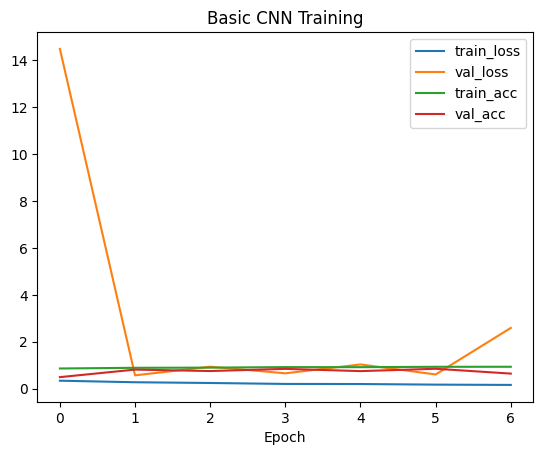

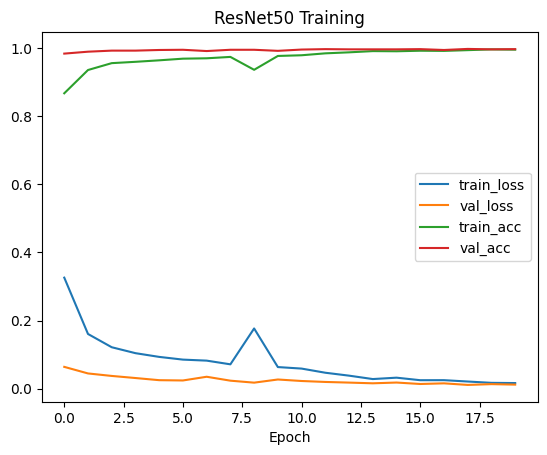

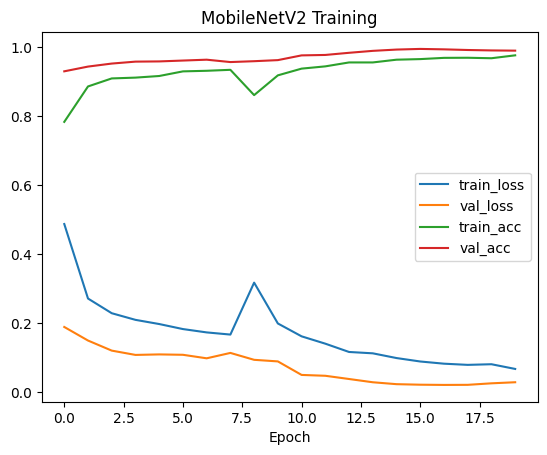

In [27]:
# Plotting Training History
def plot_history(history, title="Training"):
    plt.figure()
    plt.plot(history['loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.plot(history.get('accuracy', []), label='train_acc')
    plt.plot(history.get('val_accuracy', []), label='val_acc')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_history(cnn_history.history, "Basic CNN Training")
plot_history(resnet_history, "ResNet50 Training")
plot_history(mobilenet_history, "MobileNetV2 Training")

**MODEL EVALUATION**

In [12]:
def evaluate_model(model, test_ds, class_names):
    # Predict probabilities and labels
    y_probs = model.predict(test_ds, verbose=1)
    if y_probs.shape[-1] > 1:
        y_pred = np.argmax(y_probs, axis=-1)
    else:
        y_pred = (y_probs > 0.5).astype("int32").reshape(-1)
    # Ground truth (ordered because shuffle=False in test_ds creation)
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    # if y_true.shape[-1] > 1:
    #     y_true_idx = np.argmax(y_true, axis=-1)
    # else:
    #     y_true_idx = y_true.reshape(-1)
    
    # labels are already integer class indices
    y_true_idx = y_true.reshape(-1)


    # Metrics
    print("Classification Report:")
    print(classification_report(y_true_idx, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true_idx, y_pred)
    print("Confusion Matrix:\n", cm)

    # AUC (for binary case) otherwise per-class AUCs
    try:
        if y_probs.shape[-1] == 2:
            # take probability of class 1
            auc_score = roc_auc_score(y_true_idx, y_probs[:,1])
            print("ROC AUC (binary):", auc_score)
        else:
            # macro AUC per class
            print("AUC per class:")
            for i, cls in enumerate(class_names):
                try:
                    auc_i = roc_auc_score((y_true_idx==i).astype(int), y_probs[:,i])
                    print(f"  {cls}: {auc_i:.4f}")
                except Exception as e:
                    print(f"  {cls}: cannot compute AUC ({e})")
    except Exception as e:
        print("AUC computation failed:", e)

    return {"y_true": y_true_idx, "y_pred": y_pred, "y_probs": y_probs, "confusion_matrix": cm}

# Example usage after loading/training:
# resnet_eval = evaluate_model(resnet_model, test_ds)
# mobilenet_eval = evaluate_model(mobilenet_model, test_ds)

In [13]:
# Loading the Saved Models to Evaluate
resnet_save_path = os.path.join(MODEL_SAVE_DIR, "resnet50_final.keras")
mobilenet_save_path = os.path.join(MODEL_SAVE_DIR, "mobilenetv2_final.keras")
cnn_save_path = os.path.join(MODEL_SAVE_DIR, "cnn_final.keras")

resnet_model = keras.models.load_model(resnet_save_path)
mobilenet_model = keras.models.load_model(mobilenet_save_path)
cnn_model = keras.models.load_model(cnn_save_path)

In [14]:
print("Basic CNN")
cnn_eval = evaluate_model(cnn_model, test_ds, class_names)
print()

print("Resnet50")
resnet_eval = evaluate_model(resnet_model, test_ds, class_names)
print()

print("MobileNetV2")
mobilenet_eval = evaluate_model(mobilenet_model, test_ds, class_names)

# Benign -> Non-Cancerous
# Malignant -> Cancerous

Basic CNN
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 246ms/step
Classification Report:
                  precision    recall  f1-score   support

   breast_benign       0.75      0.97      0.85      1000
breast_malignant       0.96      0.68      0.79      1000

        accuracy                           0.82      2000
       macro avg       0.85      0.82      0.82      2000
    weighted avg       0.85      0.82      0.82      2000

Confusion Matrix:
 [[969  31]
 [324 676]]
ROC AUC (binary): 0.947072

Resnet50
63/63 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step
Classification Report:
                  precision    recall  f1-score   support

   breast_benign       0.99      1.00      0.99      1000
breast_malignant       1.00      0.99      0.99      1000

        accuracy                           0.99      2000
       macro avg       0.99      0.99      0.99      2000
    weighted avg       0.99      0.99      0.99      2000

Confusion Matrix:
 [[998   2]
 [ 14 986]]
ROC AUC (binary): 0.999861

MobileNetV2


In [15]:
def plot_confusion_matrix(model, test_ds, class_names, title="Confusion Matrix"):
    # Get predictions
    y_probs = model.predict(test_ds, verbose=1)

    # Convert probabilities to class labels
    if y_probs.shape[-1] > 1:
        y_pred = np.argmax(y_probs, axis=1)
    else:
        y_pred = (y_probs > 0.5).astype(int).reshape(-1)

    # Get ground truth labels
    y_true = np.concatenate([y for _, y in test_ds], axis=0)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step


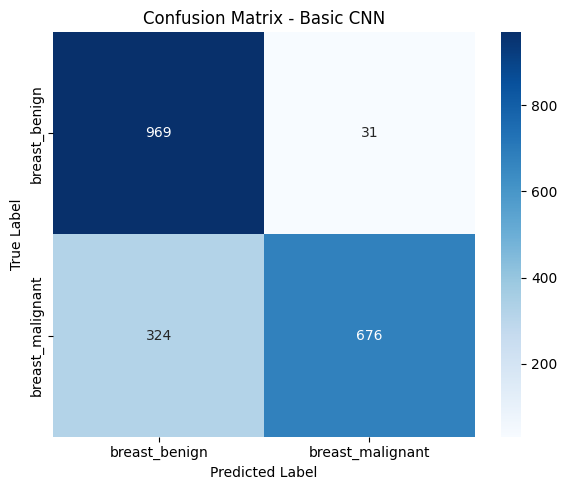

In [16]:
plot_confusion_matrix(
    cnn_model,
    test_ds,
    class_names,
    title="Confusion Matrix - Basic CNN"
)

63/63 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step


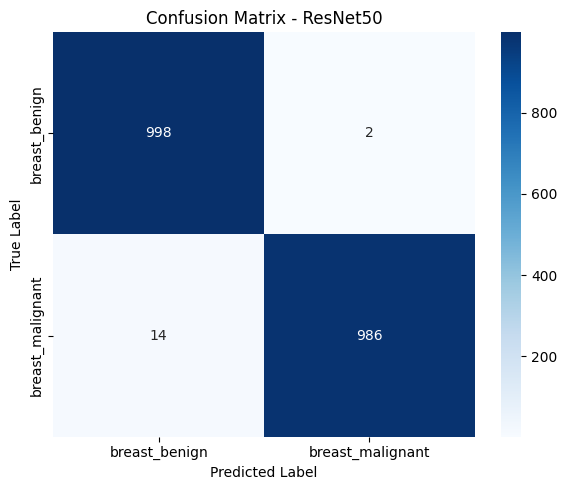

In [17]:
plot_confusion_matrix(
    resnet_model,
    test_ds,
    class_names,
    title="Confusion Matrix - ResNet50"
)

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 382ms/step


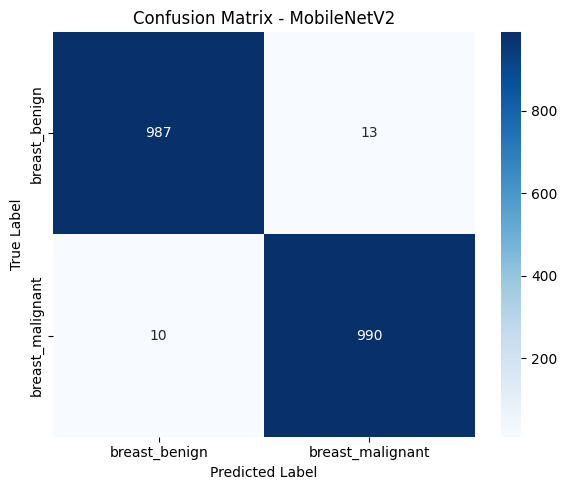

In [18]:
plot_confusion_matrix(
    mobilenet_model,
    test_ds,
    class_names,
    title="Confusion Matrix - MobileNetV2"
)